# Spectral Clustering

### Samuel BAZAZ


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


In [ ]:
pip install -r "requirements.txt"

## Setup

In [221]:
import warnings
import cv2
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.io as pio
import plotly.express as px
import scipy
from time import time
from scipy.sparse import csgraph
pio.renderers.default = "plotly_mimetype+notebook"
warnings.filterwarnings('ignore')

## Building similarity graph

In [443]:

def get_similarities(X, var=1.0):
    """
    Computes the similarity matrix for a given dataset of samples. Using a gaussian kernel

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared

    Returns
    -------
        similarities: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    return np.exp(
        -np.linalg.norm(X[None, :, :] - X[:, None, :], axis=-1) ** 2 / (2 * var)
    )

def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
    similarities = get_similarities(X, var=var)

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W[similarities >= eps] = similarities[similarities >= eps]

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """

        similarities -= np.diag(np.diag(similarities)) #no self similarities
        for i in range(n):
            closest_points = np.argsort(similarities[i])[::-1][:k] # k nearest neigbors
            W[i, closest_points] = similarities[i, closest_points]
        W += W.T #undirected graph
    return W


___eps graph___
esp=0.1


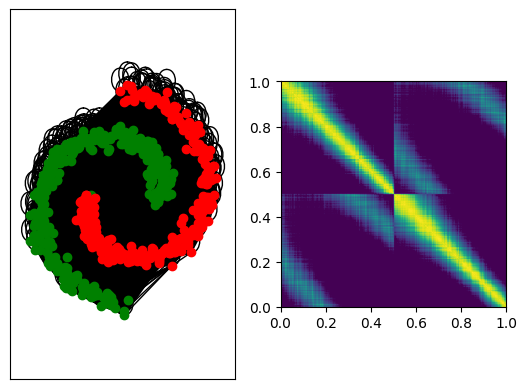

esp=0.5


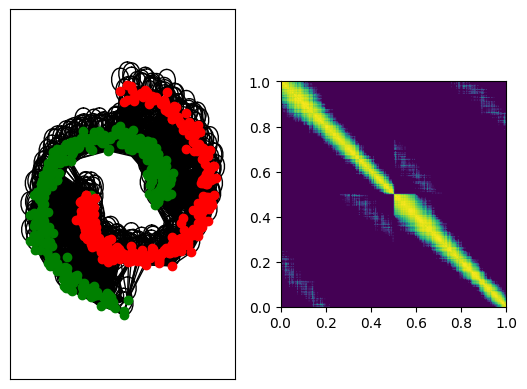

esp=0.8


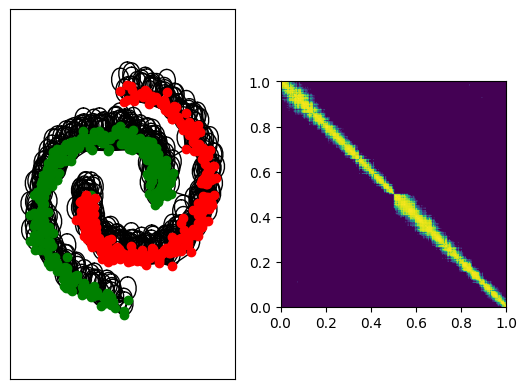

___knn graph___
k=20


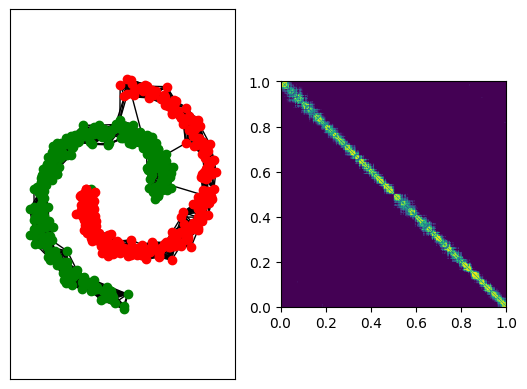

k=10


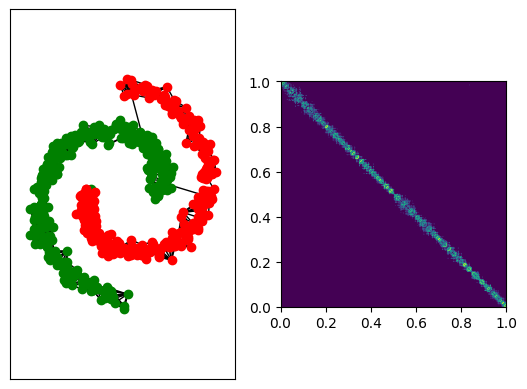

k=2


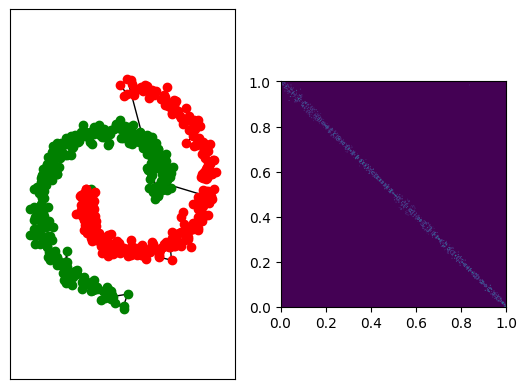

In [430]:
X, Y = two_moons(600, 1, 0.02)

print("___eps graph___")
for eps in [1e-1, 5e-1, 8e-1]:
    print(f"esp={eps}")
    W = build_similarity_graph(X, eps=eps)
    W[0, 599] = 1   
    W[10, 500] = 1   
    plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W
    
print("___knn graph___")
for k in [20,10,2]:
    print(f"k={k}")
    W = build_similarity_graph(X, k=k)
    W[0, 599] = 1    
    W[10, 500] = 1   
    plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

Le seuillage pour les ε-graphes semble bien faire diminuer le nombre de liaisons quand ce dernier augmente et la construction par k plus proches voisins a bien enlevé les "self similarities" et respecte le nombre de liaisons spécifiées. On peut observer comment un ε-graph conduit à plus de liaisons pour un des données relativement denses.

## Computing the Laplacian

In [73]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    n = W.shape[0]
    #Diagonal degree matrix
    deg = np.sum(W, axis=1)
    D = np.diag(deg)
    
    #Laplacian matrix
    if laplacian_normalization == "unn":
        L = D - W
    
    #Symmetric Laplacian matrix
    elif laplacian_normalization == "sym":
        # D**(-1/2)
        D_inv_sqrt = np.linalg.pinv(np.diag(np.sqrt(deg))) 
        L = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt
    
    #Random Walk Laplacian matrix
    elif laplacian_normalization == "rw":
        L = np.eye(n) - np.linalg.pinv(D) @ W 
        
    return L

On vérifie que les constructions des laplaciens sont correctes à partir de certaines propriétés du cours et des fonctions de scipy.

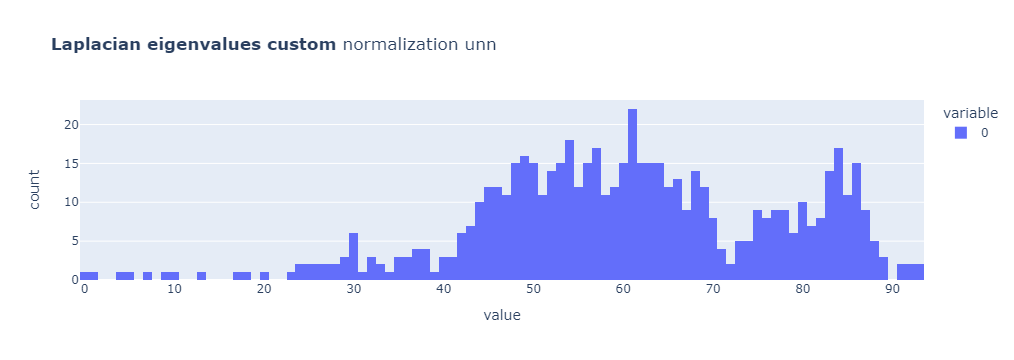

0 vector first coordinates [0.04082483 0.04082483 0.04082483 0.04082483 0.04082483]
Eigenvector 1 - 1N :
0.0

Eigenvector 1 - D**(1/2) 1N :
0.129055



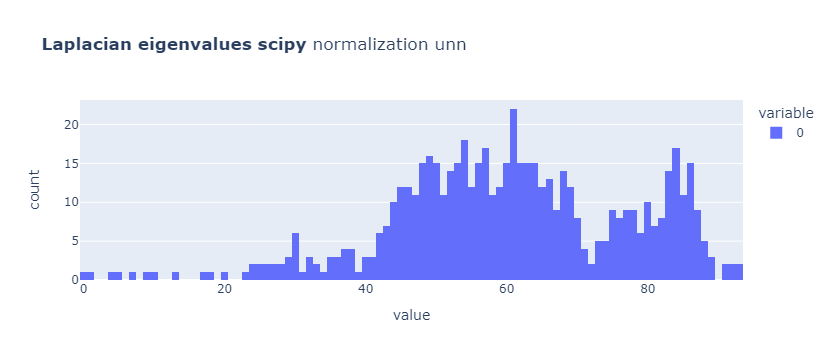

0 vector first coordinates [0.04082483 0.04082483 0.04082483 0.04082483 0.04082483]
Eigenvector 1 - 1N :
0.0

Eigenvector 1 - D**(1/2) 1N :
0.129055



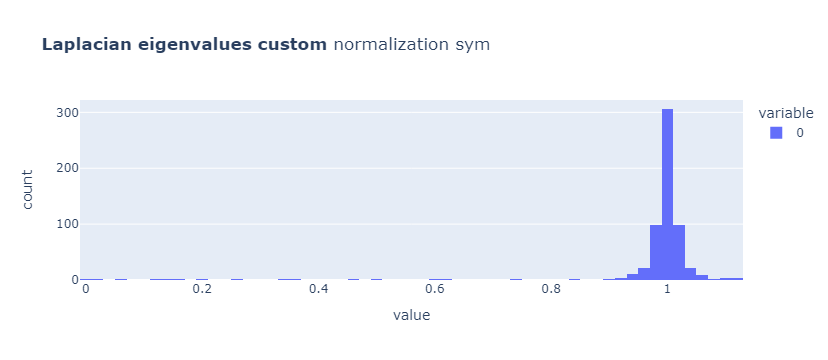

0 vector first coordinates [0.03640158 0.04222439 0.04007798 0.04436897 0.04316704]
Eigenvector 1 - 1N :
0.129055

Eigenvector 1 - D**(1/2) 1N :
0.0



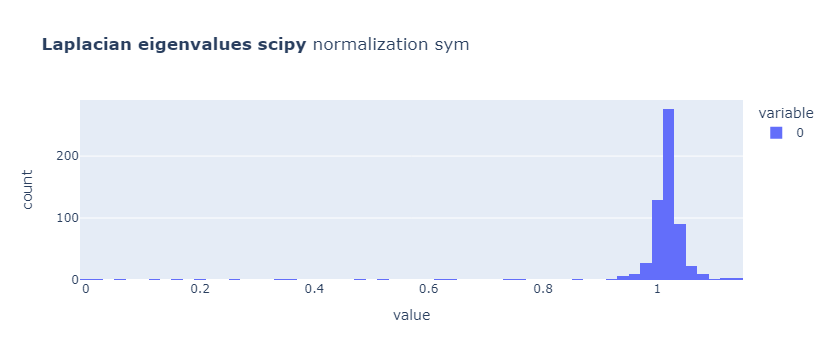

0 vector first coordinates [0.03632385 0.04224716 0.0400655  0.04442524 0.04320473]
Eigenvector 1 - 1N :
0.131342

Eigenvector 1 - D**(1/2) 1N :
0.002305



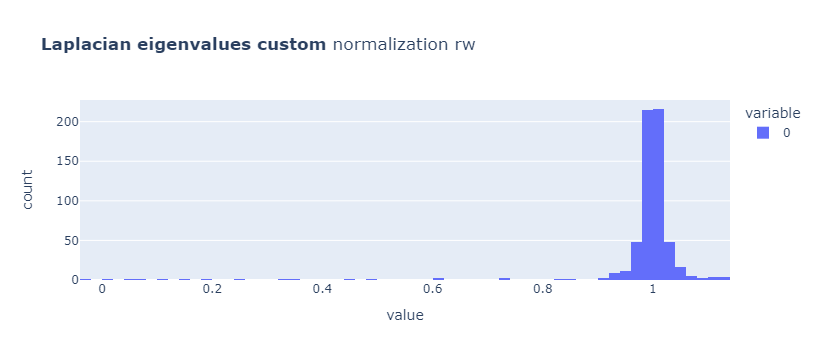

0 vector first coordinates [0.02712591 0.03728553 0.03399506 0.04224509 0.03928801]
Eigenvector 1 - 1N :
0.561343

Eigenvector 1 - D**(1/2) 1N :
0.581547



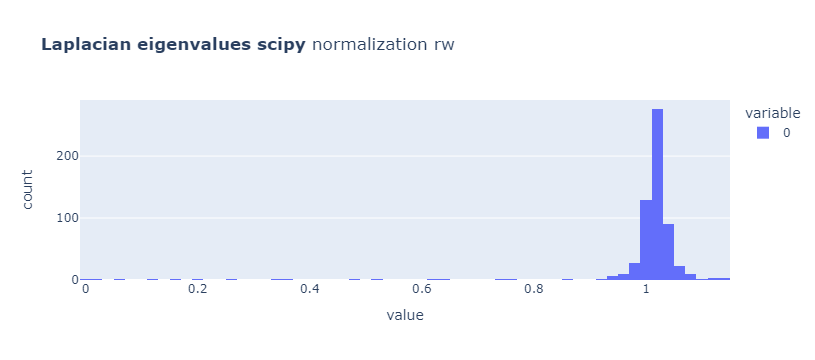

0 vector first coordinates [0.03632385 0.04224716 0.0400655  0.04442524 0.04320473]
Eigenvector 1 - 1N :
0.131342

Eigenvector 1 - D**(1/2) 1N :
0.002305



In [442]:
X, Y = two_moons(600, 1, 0.02)
W = build_similarity_graph(X, eps=0.5)

dist_normalized = lambda m1, m2 : np.linalg.norm(m1/np.linalg.norm(m1) - m2/np.linalg.norm(m2))
                                        
se_rounded = lambda m1, m2 : np.round(dist_normalized(m1,m2), 6)

ones_vec = np.ones(W.shape[0])
deg = np.sum(W, axis=1)

D_dem = np.diag(np.sqrt(deg))
D_dem_ones_vec =  D_dem @ ones_vec/np.linalg.norm(ones_vec)

for l_norm in ["unn", "sym", "rw"]:
    L = build_laplacian(W, laplacian_normalization=l_norm)
    if l_norm == "unn":
        L2 = csgraph.laplacian(W)
    elif l_norm == "sym":
        L2 = csgraph.laplacian(W, symmetrized=True, normed=True, use_out_degree=True)
    else:
        L2 = csgraph.laplacian(W, symmetrized=False, normed=True)
    
    for funct in ["custom","scipy"]:
        if funct=="custom":
            eigenvalues, eigenvectors = np.linalg.eigh(L)
        else:
            eigenvalues, eigenvectors = np.linalg.eigh(L2)
            
        px.histogram(eigenvalues, title = f" <b>Laplacian eigenvalues {funct}</b> normalization {l_norm}", nbins = 100).show()
        for i in range(len(eigenvalues)):
            if np.abs(eigenvalues[i]<1e-4):
                
                print("0 vector first coordinates",eigenvectors[:5, i])
                print(f"Eigenvector {i + 1} - 1N :\n{se_rounded(eigenvectors[:, i], ones_vec)}\n")
                print(f"Eigenvector {i + 1} - D**(1/2) 1N :\n{se_rounded(eigenvectors[:, i], D_dem_ones_vec)}\n")

La construction du Laplacien est bonne pour ce qui est de la version non normalisé, on a bien le bon vecteur propre pour 0 et la même distribution des valeurs propres que la fonction scipy. 
Hélas pour ce qui est des Laplaciens normalisés, on recupère certes le bon nombre de composantes connexes mais mais l'erreur numérique apportée par l'opération de normalisation ne nous permet pas d'obtenir les bons vecteurs propres. Aussi on peut constater que la fonction de scipy ne semble pas séparer la version symmétric de la version random walk. Nous utiliserons donc notre version pour le calcul du Laplacien.

## Clustering

In [547]:
def choose_eigenvalues(eigenvalues):
    """
    Function to choose the indices of which eigenvalues to use for clustering.

    :param eigenvalues: sorted eigenvalues (in ascending order)
    :return: indices of the eigenvalues to use
    """
    gaps = eigenvalues[1:] - eigenvalues[:-1]
    last_index = 0
    threshold = 0.2
    for idx, gap in enumerate(gaps):
        if gap > threshold:
            last_index = idx + 1
    return list(range(last_index + 1))


def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, plot = False):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)

    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """
    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eigenvalues, eigenvectors = scipy.linalg.eig(L)
    permut = eigenvalues.argsort()  
    eigenvalues = eigenvalues[permut].real
    U = eigenvectors[:,permut].real
    E = np.diag(eigenvalues)
    if plot:
        px.histogram(eigenvalues, title = f" <b>Laplacian eigenvalues </b>", nbins = 100).show()
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    if chosen_eig_indices is None:
        # Pour choisir le nombre de composantes on regarde déjà quand les valeurs propres sont non nuls
        non_zero_indx = sum(eigenvalues<1e-6) + 1
        # On calcule ensuite les variations des valeurs propres
        # pour savoir quand est ce que il y a un gap important
        # il s'avère que la variation relative est un peu meilleure
        #get_jump = lambda v,k: (v[k+1] - v[k]) / (v[k]+ 1e-9)
        get_jump = lambda v,k: (v[k+1] - v[k])
        get_jump_eig = np.vectorize(lambda i: get_jump(eigenvalues, i))
        
        eigengaps = get_jump_eig(np.arange(non_zero_indx, len(eigenvalues)-1))
        chosen_eig_indices = np.arange(np.argmax(eigengaps) + non_zero_indx + 1)
    if plot:
        px.line(U[:, chosen_eig_indices].real, title="<b>Choosen eigenvectors</b>").show()
    kmeans = KMeans(n_init="auto", n_clusters=num_classes)
    Y = kmeans.fit_predict(U[:, chosen_eig_indices].real)
    
    return Y

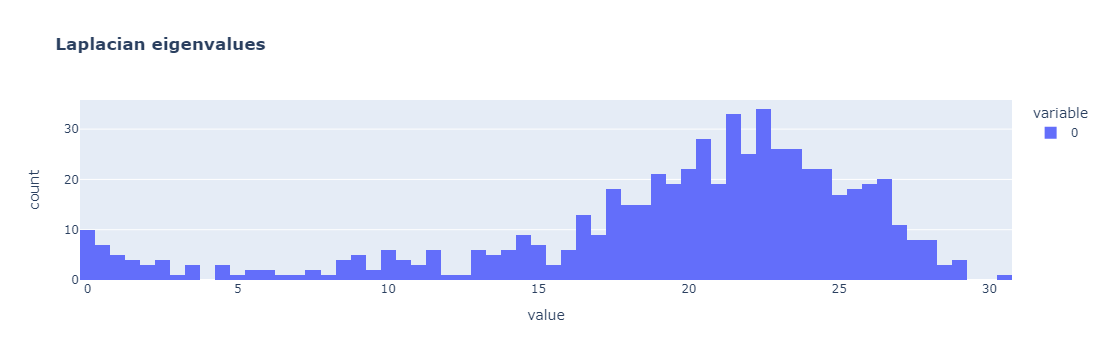

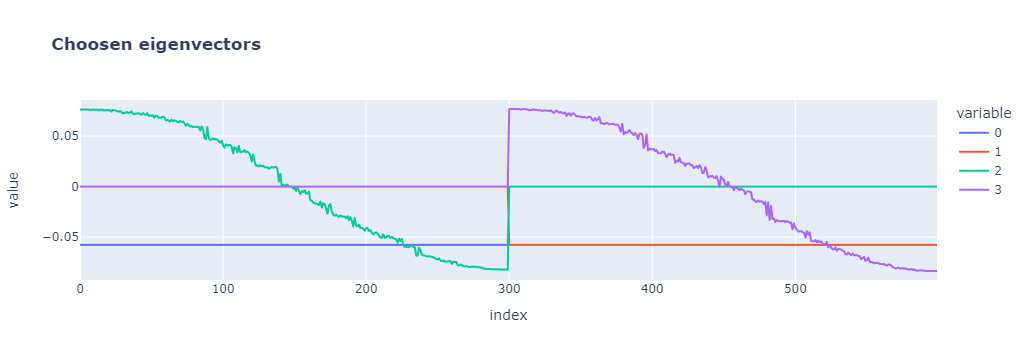

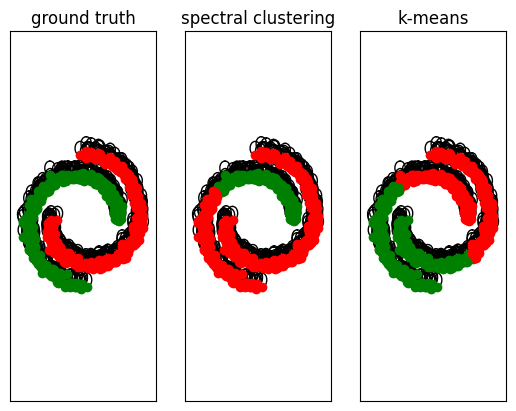

In [294]:
# Example
X, Y = two_moons(num_samples=600)
W = build_similarity_graph(X, k=10)
num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, plot=True)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

On observe qu'à la différence du k-means nous n'avons pas comme prior d'avoir des proportions équivalentes entre les clusters. Comme le graphe est connecté dans notre cas le mincut conduit à éliminer qu'un faible fragment et ce sans réussir à séparer les deux croissants. Cependant ce point peut être amélioré par la normalisation du Laplacien au vu des liens entre ces méthodes et les problèmes Cut et NCut.

## Parameter sensitivity 

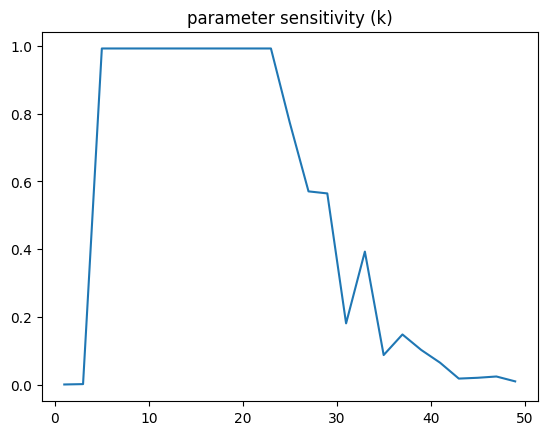

In [298]:
def parameter_sensitivity(parameter_type="k", laplacian_normalization = "rw", var = 1, chosen_eig_indices = list(range(1,2))):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose candidate parameters
    """
    
    if parameter_type == "k":
        parameter_candidate = list(
            range(1, 50, 2)
        ) 
    else:
        parameter_candidate = np.linspace(0, 1, 20)  
    parameter_performance = []
    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}

        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

parameter_sensitivity()

## Image segmentation

In [189]:
def image_segmentation(input_img='four_elements.bmp', laplacian_normalization = 'unn', num_classes = 2, chosen_eig_indices = [1], var = 1.0, k = 2):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """
    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

Pour la segmentation nous pouvons déjà utiliser certains prior. Il y a 5 composentes de bases fréquences spatiales, d'où le règlage suivant.

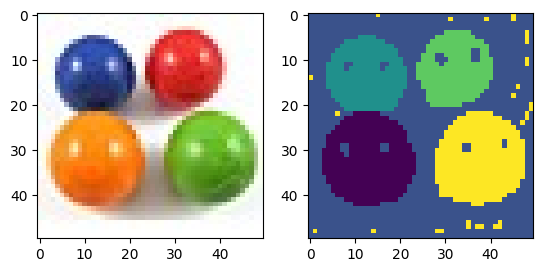

In [196]:
image_segmentation(laplacian_normalization = 'rw', num_classes = 5, chosen_eig_indices = list(range(1, 7)),  k = 10)

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

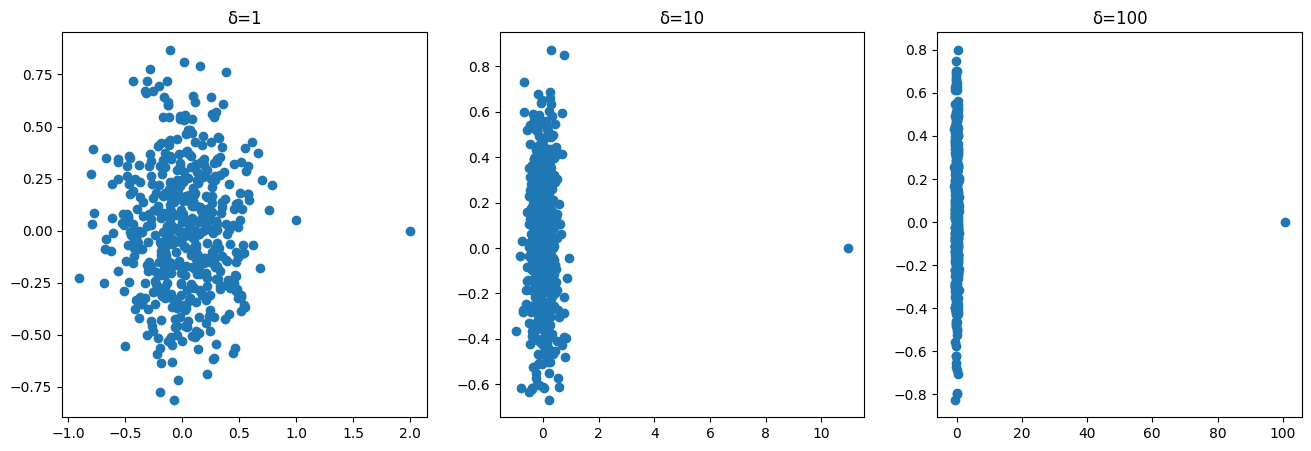

In [201]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
for i, δ in enumerate([1, 10, 100]):
    X, Y = worst_case_blob(500, delta=δ)
    axs[i].plot(X[:, 0], X[:, 1], "o")
    axs[i].set_title(f"δ={δ}")

worst_case_blob sert à générer une distribution gaussienne centrée réduite avec un outlier sur l'axe des abscisses en δ+1.

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

Le min_span_tree nous assure la connexité, ainsi il suffit que ce dernier soit un sous graphe de notre ε-graph. 
On utilise ainsi min_span_tree pour calculer la similarité la plus faible de manière à placer le seuillage en dessous de cette valeur, concervant ainsi l'aubre minimal dan sla construction du ε-span.

In [500]:
def get_eps_by_mst(X, Y, var=1.0):
    similarities = get_similarities(X, var=var)
    tree_mask = min_span_tree(similarities)
    tree = np.zeros_like(similarities)
    tree[tree_mask] = similarities[tree_mask]
    plot_graph_matrix(X, Y, tree)
    return tree[tree_mask].min()

L'acyclicité de la structure d'arbre nous assure que pour avoir un graphe complet il suffit que la somme des noeuds soit égale au nombre de liaisons de l'arbre -1. On a ainsi un moyen de vérifier que notre graphe est effectivement connecté.

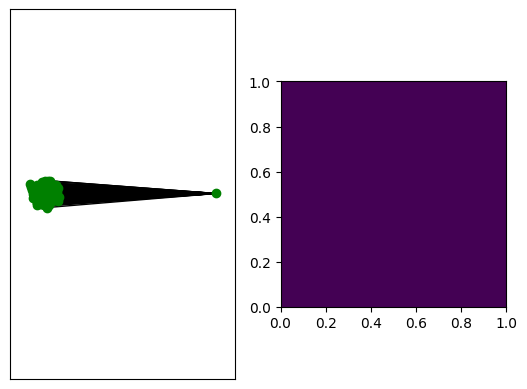

εopt = 0.493
The graph is fully connected :  True


In [524]:
δ=10
var = δ**2
X, Y = worst_case_blob(500, delta=δ)
εopt = get_eps_by_mst(X, Y, var=var)
print(f"εopt = {np.round(εopt,3)}")
W = build_similarity_graph(X, eps=εopt, var= var)
tree = min_span_tree(W)
print("The graph is fully connected : ", np.sum(tree) == W.shape[0] - 1)

Le paramètre de similarité σ a été fixé égale à ε afin d'éviter un underflow qui empêche la connexité de notre graphe malgré le seuillage adapté. En conséquence, le noyau gaussien est bien moins local lorsque δ augmente, et les noeuds s'éloignent comme lorsque lorsque l'on augmente la dimension. On peut facilement voir comment cela masquerait les structure locales dans un clustering et pourquoi cette méthode n'est pas viable quand un outlier est trop éloigné.
La méthode ε-graph n'est ainsi pas robuste aux outliers et au variations d'échelles, cette denière se fondant que sur un unique ordre de gradeur. 

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

Dans le cadre du spectral clustering, si il y a des composantes connexes l'algorithme enverra par défault ces dernières. Cela est problématique quand ce découpage ne suit pas le clustering réel, par exemple quand il y a plus de composantes que de clusters, ce qui est souvent le cas. Donc excepté lorsque la séparation est connue et fait sens, on préfère avoir la connexité et discriminer à posteriori les composantes justement par le spectral clustering. 

Aussi, il y a des appliquations qui necessitent la connexité, par exemple pour comparer des noeuds pour des recommandations on a besoin que ces derniers communiquent ( au sens de la relation d'équivalence de communication ). Ensuite, lorsque le graphe n'est pas connecté, on ne peut pas assurer que l'on peut atteindre tous les noeuds ce qui peut être limitant lorsque l'on cherche à detecter des communautés. En somme, il y a un ensemble d'usages autres que le cultering spectral qui motivent l'intérêt d'avoir un graphe connecté. 

In [530]:
def plot_analysis_k_eps(X, Y):
    print("___eps graph___")
    for eps in [0,.5, 0.9]:
        print(f"esp={eps}")
        W = build_similarity_graph(X, eps=eps)
        plot_graph_matrix(X, Y, W) 
    
    print("___knn graph___")
    for k in [100,50,10]:
        print(f"k={k}")
        W = build_similarity_graph(X, k=k)
        plot_graph_matrix(X, Y, W)  

___eps graph___
esp=0


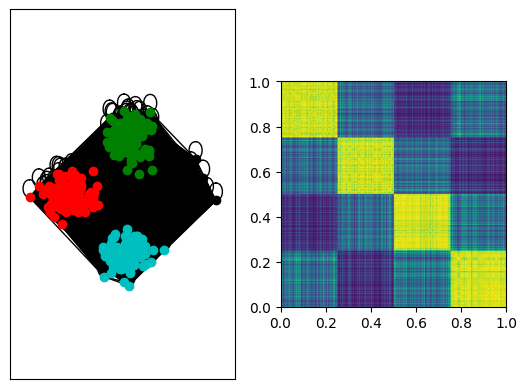

esp=0.5


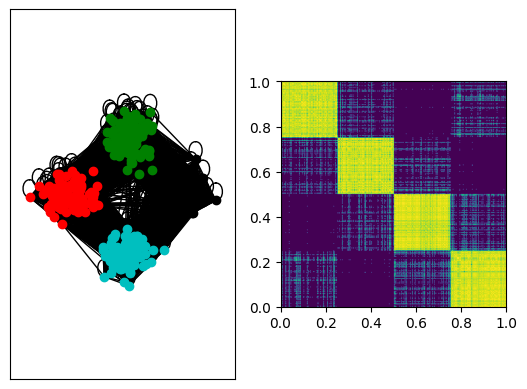

esp=0.9


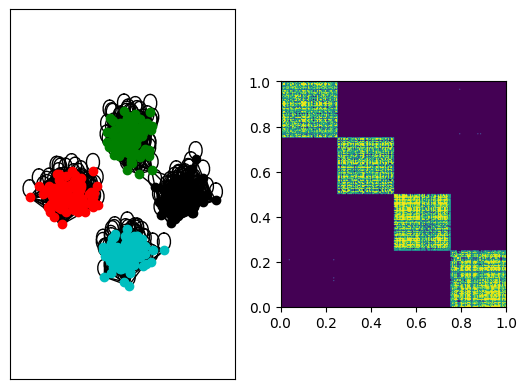

___knn graph___
k=100


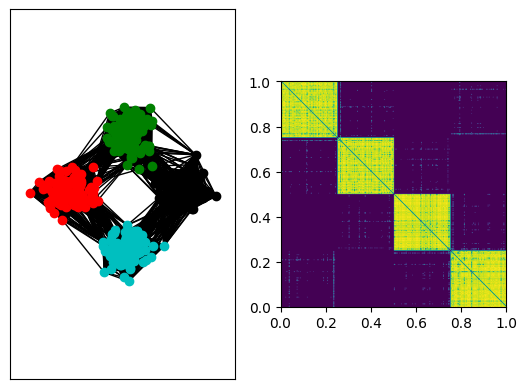

k=50


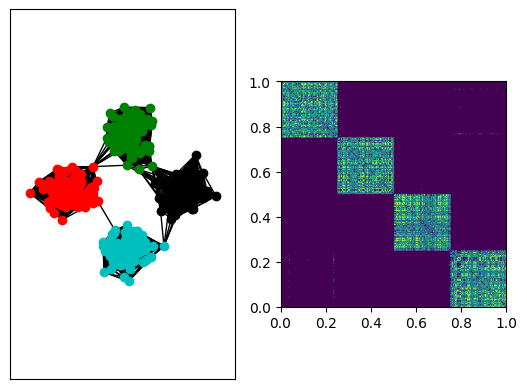

k=10


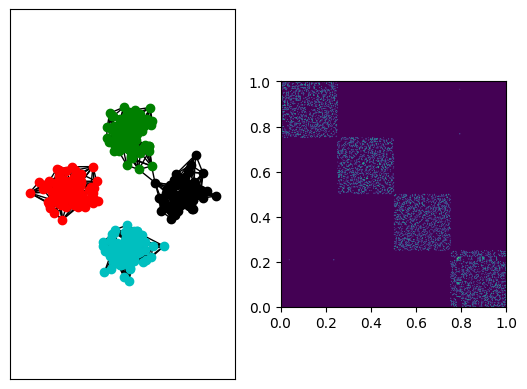

In [531]:
plot_analysis_k_eps(*blobs(400, n_blobs=4, blob_var=0.2))

___eps graph___
esp=0


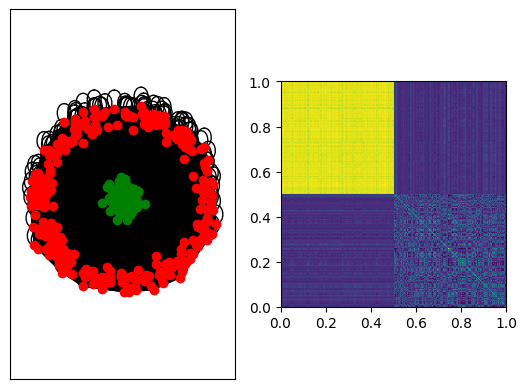

esp=0.5


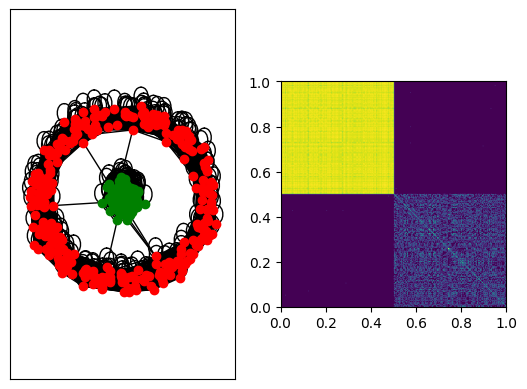

esp=0.9


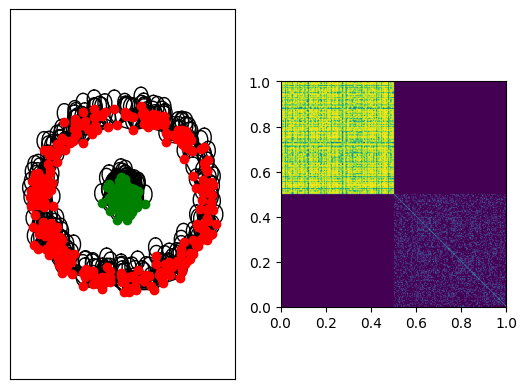

___knn graph___
k=100


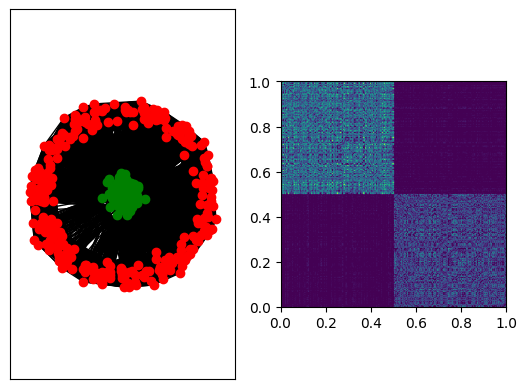

k=50


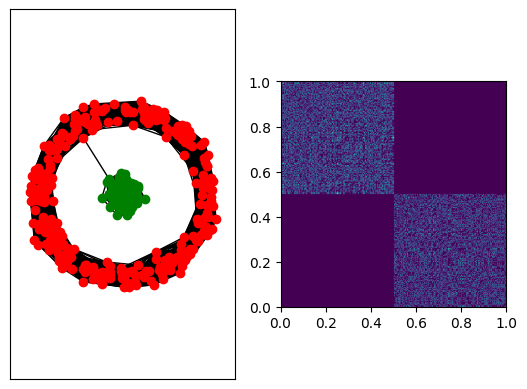

k=10


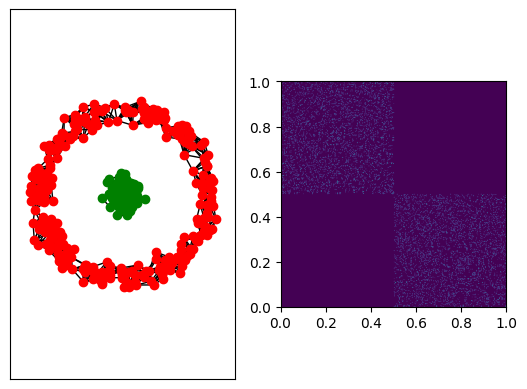

In [533]:
plot_analysis_k_eps(*point_and_circle(num_samples=600))

___eps graph___
esp=0


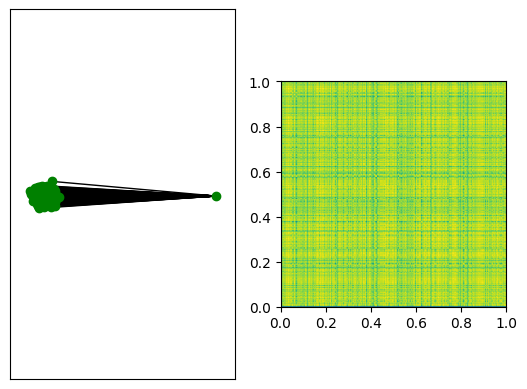

esp=0.5


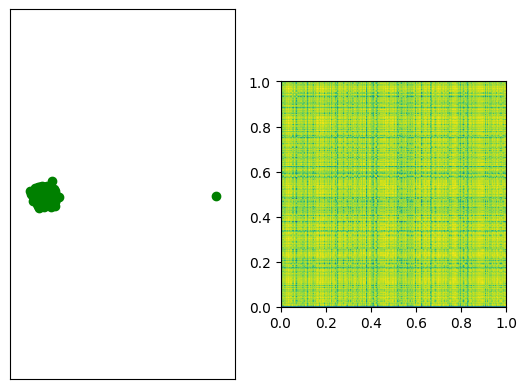

esp=0.9


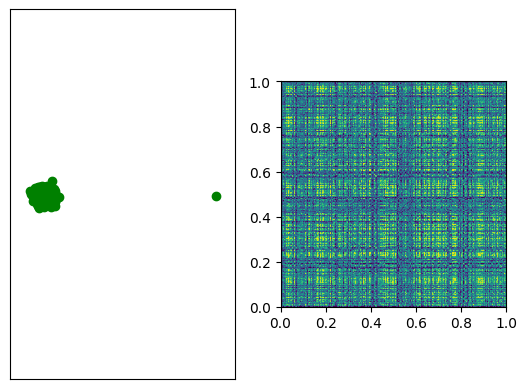

___knn graph___
k=100


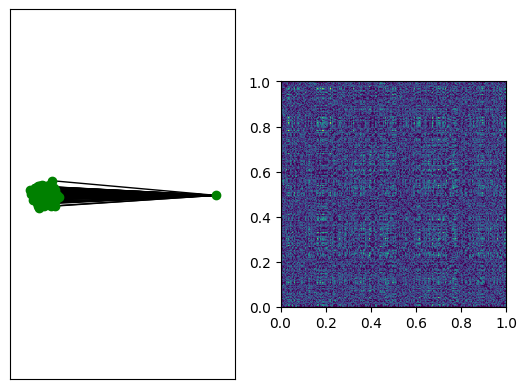

k=50


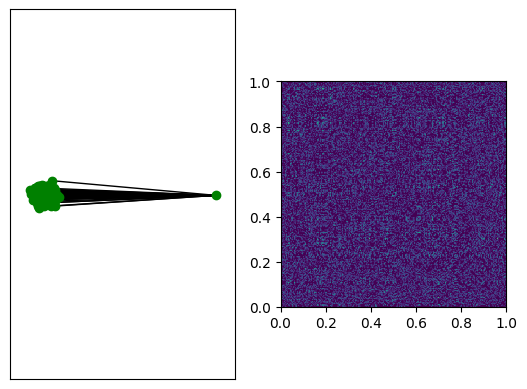

k=10


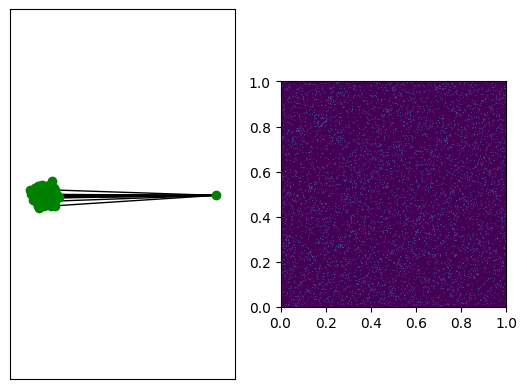

In [532]:
plot_analysis_k_eps(*worst_case_blob(500, delta=10))

Comme observé précédemment, les ε-graphes sont difficiles à régler lorsque on a plusieurs échelles: les points proches vont rapidement se lier avant que des points éloignés communiquent. Les k-nn graphes sont plus robuste aux variations de densités, cependant il faut adapter aussi le paramètre k pour assurer la connexité, surtout quand il y a des régions de forte densités, en témoigne la figure point_and_circle pour k=10. 
Un résultat de Brito et al de 1997 nous assure qu'il suffit de prendre k= log(n), mais comme c'est un résultat asymptotique, il faut tester empiriquement tout de même. 
Enfin, il est important de souligner que ce qui fait la faiblesse des ε-graphes peut devenir une force : ces derniers peuvent servir à éliminer les outliers.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

On a ici des régions très denses et les deux clusters sont relativement proches, ce qui nous motive à choisir un ε-graph. En effet il faudrait choisir k très élevé pour réussir à connecter les deux composantes.
Suite à plusieurs essaies on constate que utiliser un Laplacien normalisé offre de meilleurs résultats. Cela se comprend par l'interprétation du Random walk : le Ncut se décompose en la probabilité de transition entre les deux clusters et au vu de la concentration de ces dernières, cela amène à les séparer avec une grande probabilité.
Enfin,pPour le choix des vecteurs propres, on élimine le premier qui est associé à l'unique composante connexe (que des 1), ce qui n'apporte aucune information. Le deuxième suffit à lui même en étant une indicatrice de l'appartence à un des deux cluster : on ne peut pas faire mieux.

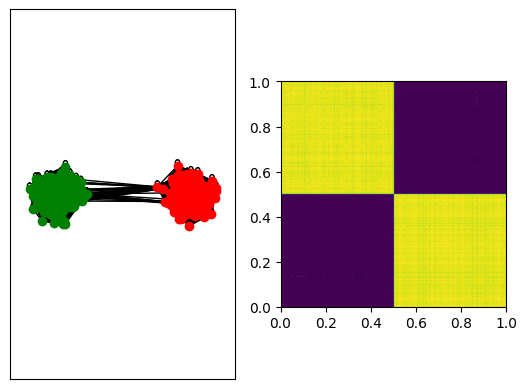

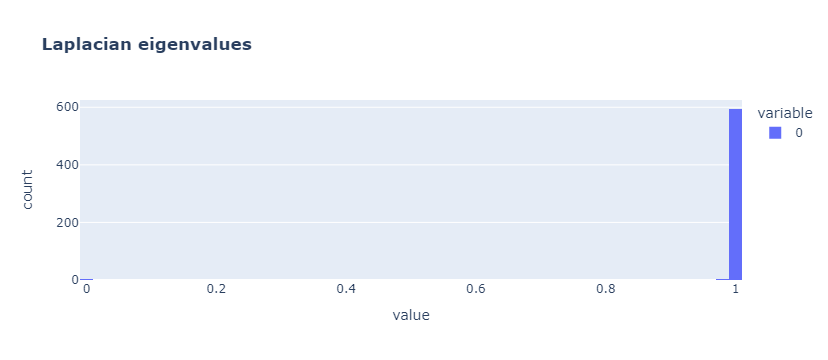

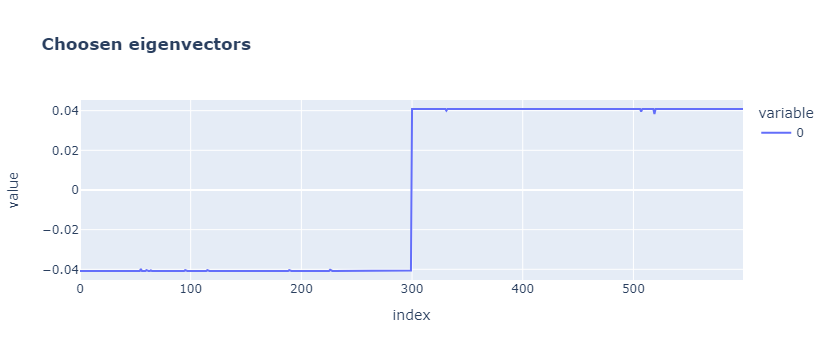

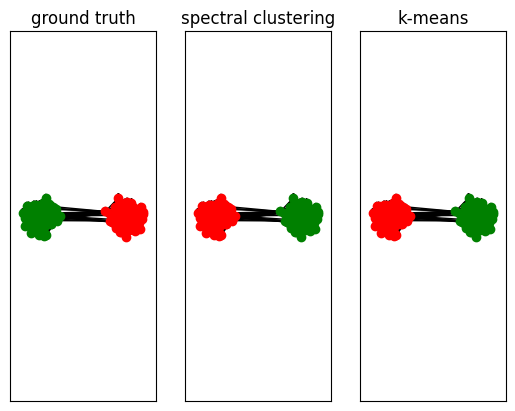

In [540]:
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, eps=0.45)
plot_graph_matrix(X, Y, W)
num_classes = 2
L = build_laplacian(W, laplacian_normalization='rw' )
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes, plot=True)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

On peut noter tout de même qu'un k-means serait suffisant pour ce type de distribution au vu de la compacité des clusters et de leur séparation linéaire stricte.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

Nous allons diminuer la connectivité en utilisant cette fois un k-nn graphe de manière à avoir deux composantes connexes séparées. Après quelques essaies nous remarquons que les vecteurs propres qui ont des variations à haute fréquences sont plus suceptible d'induire des erreurs de clustering en subdivisant une composante connexe. 

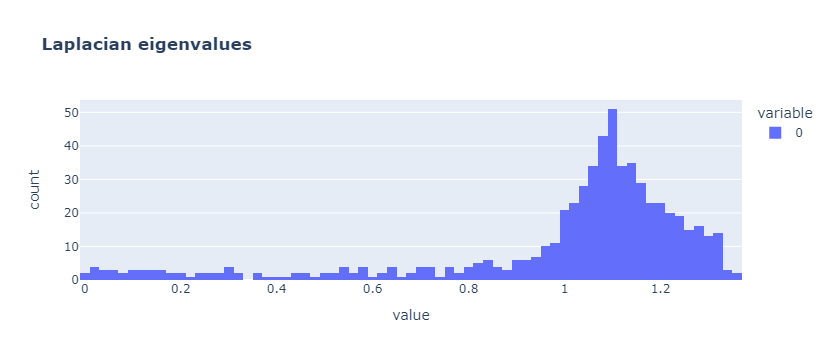

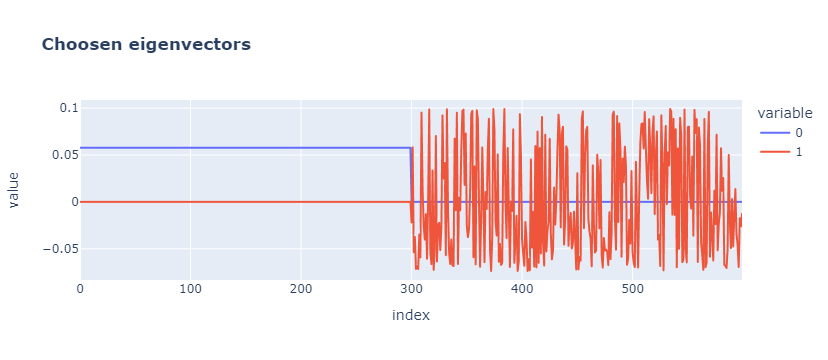

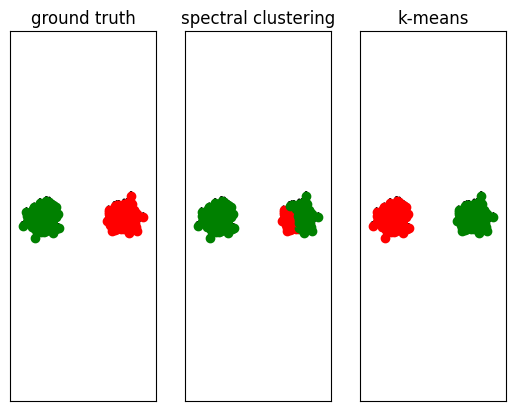

In [541]:
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, k=10)
num_classes = 2
L = build_laplacian(W, laplacian_normalization='rw' )
Y_rec = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes, plot=True)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

En se restreignant au premier vecteur, on retrouve évidement une bonne classification vu que le vecteur propre est encore proche d'une indicatrice. 

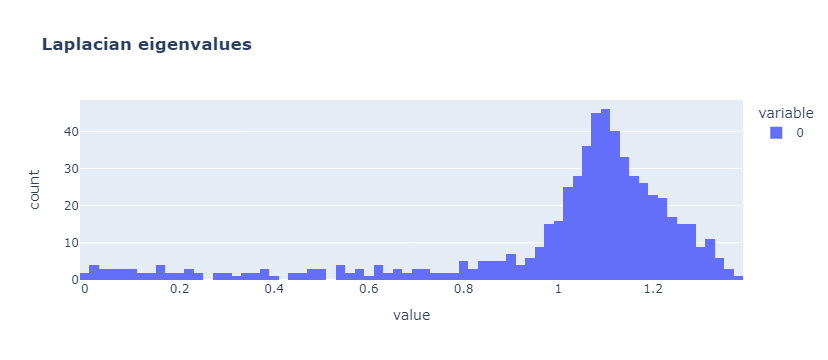

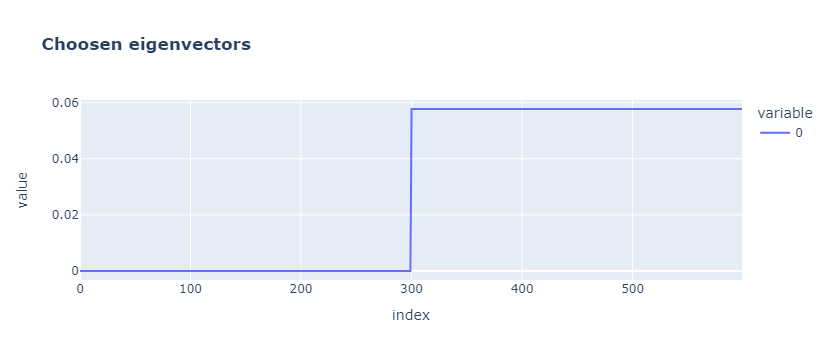

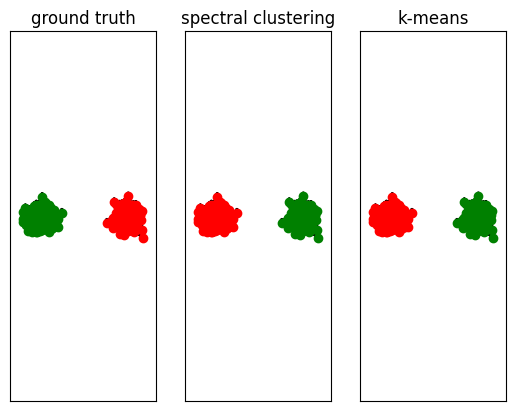

In [542]:
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, k=10)
num_classes = 2
L = build_laplacian(W, laplacian_normalization='rw' )
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes, plot=True)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Il est donc important de limiter le nombre de vecteurs propres considéré lorsque la connexité n'est pas assurée.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

Pour déterminer automatiquement les vecteurs on utilise l'heuristique du max spectral gap. L'idée est d'ajouter les vecteurs propres jusqu'au moment où les valeurs propres associée sont grandes. L'idée dernière cette méthode est que les premières valeurs propres sont associée à des variation de faibles fréquence et sont ainsi les plus pertients pour des problématiques de Cut ou NCut. Il y a aussi certains résultats de la théorie de la perturbation qui motive cette heuristique, avec nottamment le théorème de Davis Kahan mais ça dépasse mes compétences.

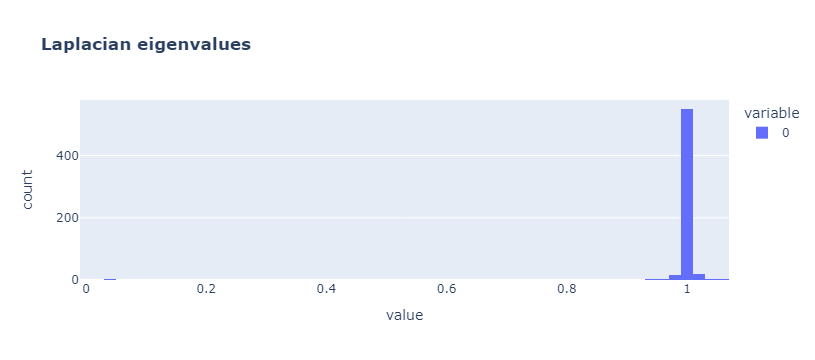

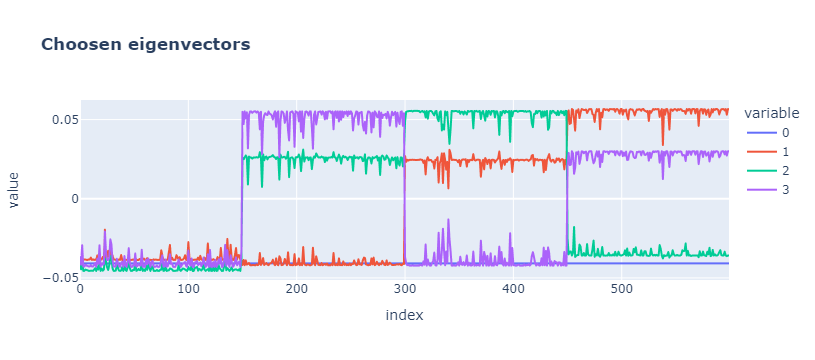

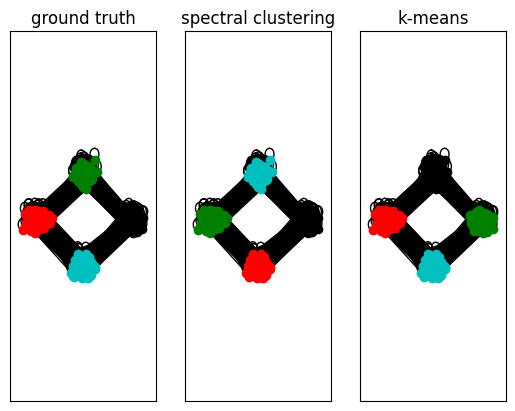

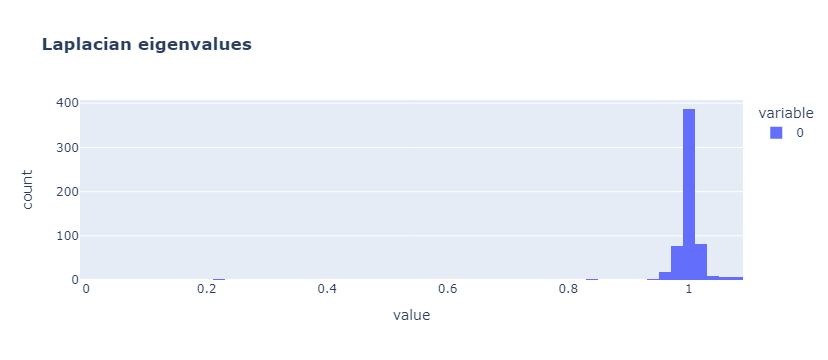

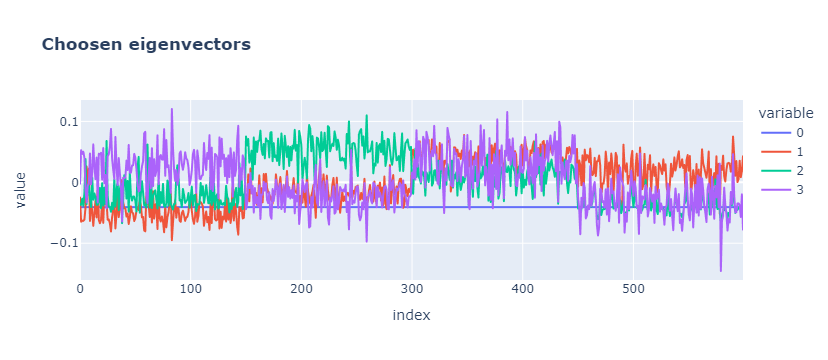

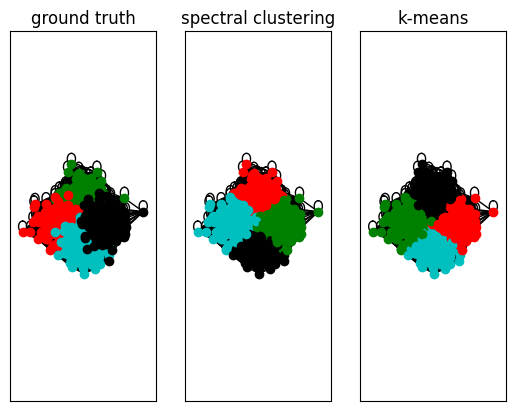

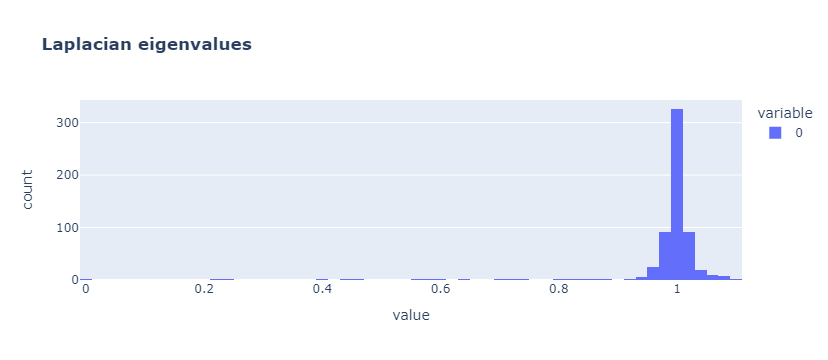

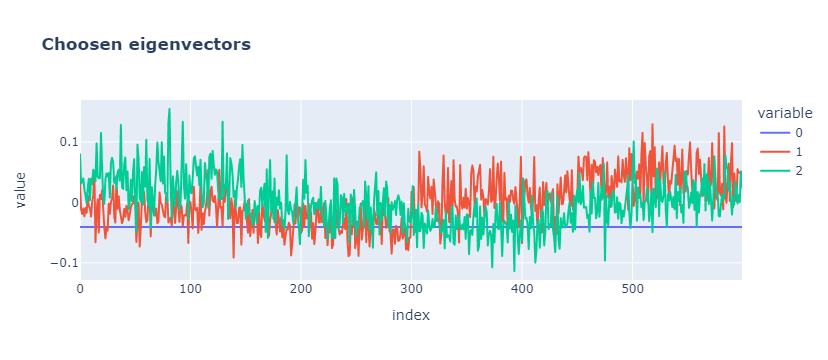

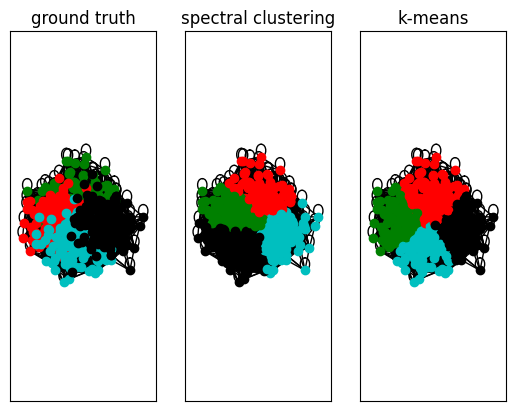

In [548]:
for var in [0.10, 0.50, 0.70]:
    X, Y = blobs(num_samples=600, n_blobs=4, blob_var=var)
    W = build_similarity_graph(X, eps=0.5)
    num_classes = 4
    L = build_laplacian(W, laplacian_normalization='rw' )
    Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, plot=True)
    
    # Plot results, comparing to KMeans
    plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Lorsque les clusters se mélangent avec l'augmentation de la variance le nombre de vecteur considérés diminue ce qui rejoind le constat précédent, de favoriser les vecteur à basse fréquence afin d'éviter une subdivision d'un cluster. Ensuite on observe que les vecteurs propres s'éloignent de la situtation optimale où elle sont des indicatrices des clusters: elles sont de plus en plus bruitées et de moins en moins constant par morceaux.
Enfin, on remarque que le résultats s'approche de celui d'un k-means en raisson de la compacité croissante du nuage de point.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

La selection des vecteurs propres du Laplacien est associée à une relaxation continue et convexe du programme Cut ou NCut qui sont NP-Hard. On récupère ainsi des classifier dis soft ce qui nous oblige à ajouter une étape de classification à la fin, d'où ces étapes de thresholding ou de k-means. Le choix de la méthode dépend des caractéristiques de la représentation ainsi obtenu. Le thresholding est simplement une séparation linéaire par un hyperplan de l'embedding et on comprend bien que cela ne fonctionne que lorque nos embedding sont linéairement séparables, donc lorsque nos vecteurs propres sont pas trop loins d'être des indicatrices et que le nombre de clusters à identifier n'est pas trop grand. On pourrait imaginer d'autres approches de classification plus robustes : SVM, XGboost... Le k-mean en est une et offre déjà de bonne propriétées d'où son utilisation ici.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

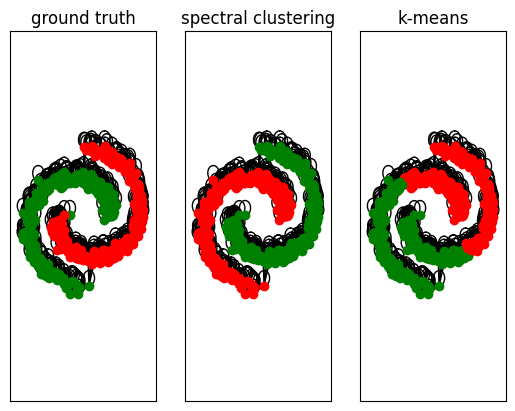

In [317]:
X, Y = two_moons(500, 1, 0.02)
W = build_similarity_graph(X, k=18)
num_classes = 2
L = build_laplacian(W, laplacian_normalization='rw' )
Y_rec = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes, plot=False)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Le spectral clustering maximise la connectivité des clusters alors que k-means maximise la compacité des clusters. Cela explique pourquoi k-means coupe les croissants de lune de manière à délimiter des composantes convexes. Une autre différence dans le cas où l'on utilise un Laplacien non normalisé est que ce dernier accepte de grands deséquilibres dans les classes comme on le verra dans la question suivante.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

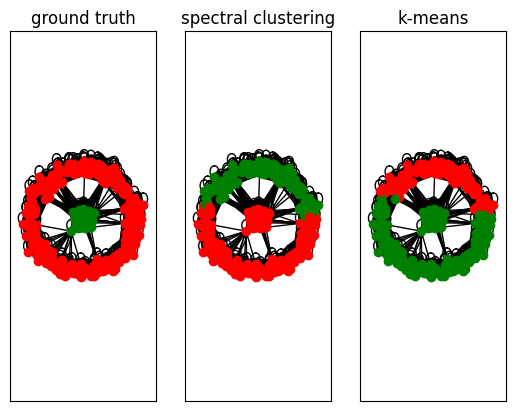

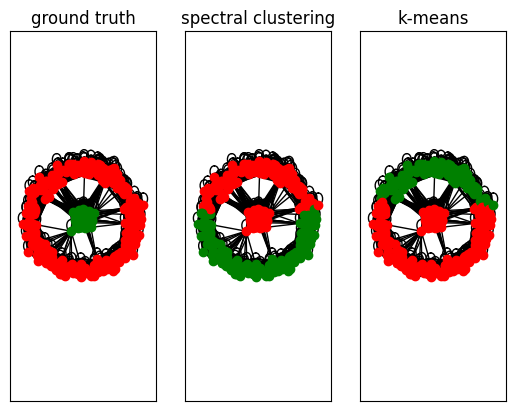

In [563]:
X, Y = point_and_circle(num_samples=600)

W = build_similarity_graph(X, eps=0.4)
num_classes = 2

L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes, plot=False)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

L = build_laplacian(W, laplacian_normalization='rw' )
Y_rec = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes, plot=False)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

La différence entre utiliser un Laplacien normalisé ou non normalisé tient pour beaucoup de la différence entre la problème Cut et Ncut. Le problème Ncut prend en compte en plus des similarités extra clusters le volume des cluters (La somme des degrés). Ainsi lorsque les degrés sont relativement homogènes les deux méthodes sont très proches, ce qui est le cas ici. Une légère différence de connectivité entre la porption haute et basse explique la différence d'attibution des deux méthodes. La version normalisé semble être cependant plus validé par des résultats théoriques, car elle permet d'utiliser la litérature sur les processus markoviens, les questions d'ergodicité, de mesures invariantes ...

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

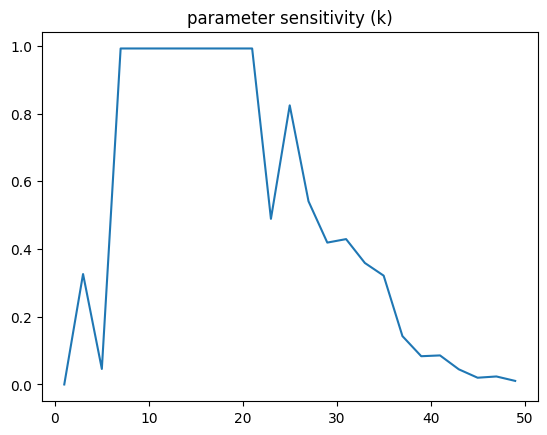

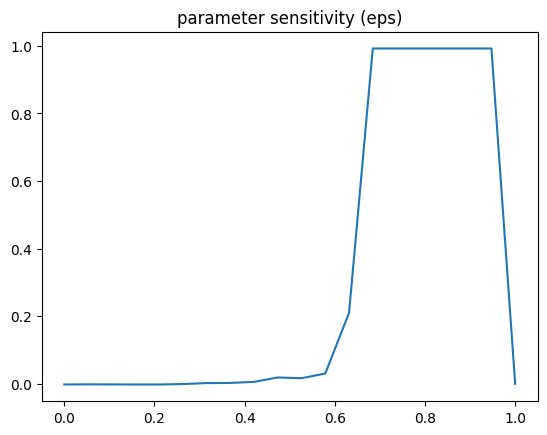

In [564]:
parameter_sensitivity(parameter_type="k")
parameter_sensitivity(parameter_type="eps")

On rappelle que la distribution utilisée ici est les two moon, et on peut s'attendre à des résultats très différentes pour d'autres distributions. 

Quand k augmente on obtient rapidement la connexité du graphe ce qui explique l'augmentation rapide de la performance pour k>5. Pour k<25 on peut suposer que les noeux d'une lune commence à se connecter à l'autre lune, ce qui conduit à dégrader le clustering en augmentant la communication entre les deux composantes et en rendant ainsi moins probable le fait de les séparer.

On peut constater une situation analogue mais inversée pour ε : tant que ε est faible les deux croissants sont trop connectés pour être bien séparés, jusqu'au moment où cette communication extra cluster devient suffisament faible en compararaison de la communication intracluster: c'est l'augmentation rapide autour ε=0.6. Enfin pour ε proche de 1 on perd la connexité d'où la baisse de performance.   

Ces interprétations se vérifient, en témoignent les visualisations suivantes:

k=5


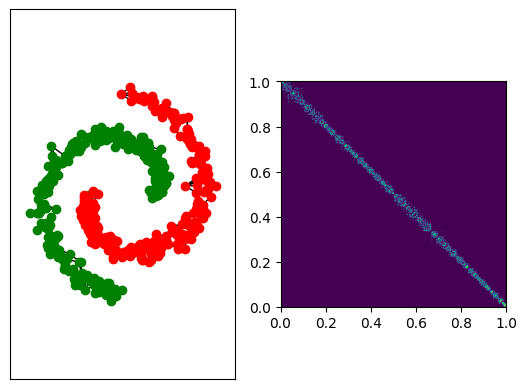

k=15


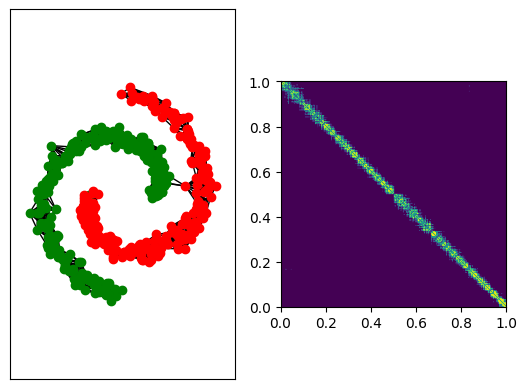

k=30


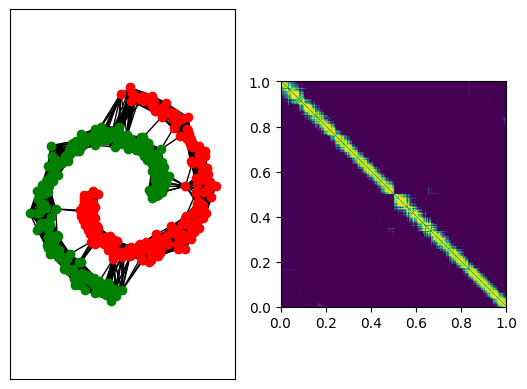

eps=0.5


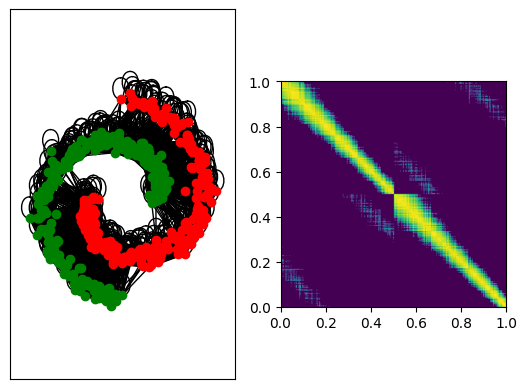

eps=0.8


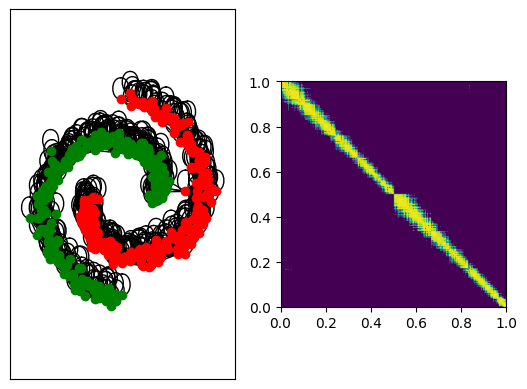

eps=0.95


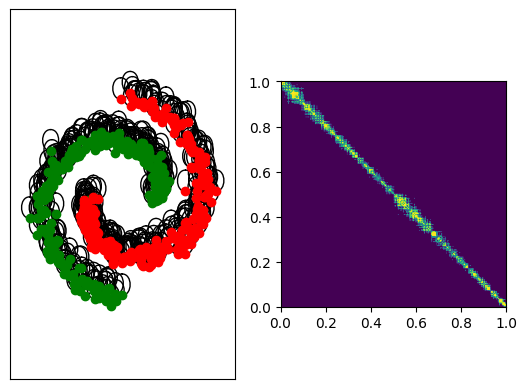

In [569]:
def test_two_moon(X, Y, k=None, eps=None):
    if k:
        W = build_similarity_graph(X, k=k)
        print(f"k={k}")
    else:
        W = build_similarity_graph(X, eps=eps)
        print(f"eps={eps}")
    plot_graph_matrix(X, Y, W)

X, Y = two_moons(500, 1, 0.02)
for k in [5,15,30]:
    test_two_moon(X, Y, k=k, eps=None)
for ε in [0.5, 0.8, 0.95]:
    test_two_moon(X, Y, k=None, eps=ε)

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

Il existe de nombreuses approches pour la validation d'un modèle non supervisé. 

Le plus simple est de mesurer la stabilité de notre clustering comme avec le critère Rand, mais cela nous donne aucune garantie sur la qualité du clustering.

Le plus efficace mais difficile a mettre en place, est d'utiliser un modèle probabiliste sur les données avec une loi de mélange. On peut par exemple estimer la vraisemblance d'un modèle Gaussien par algorithme EM, hélas ce prior n'est pas adapté à nos two moon dont les modes sont étalés. Pour des distributions de ce type il faudrait employer des méthodes d'échantillonnage plus sophistiquées comme un parallel tempering ou une HMC pour estimer la loi à posteriori, mais cela requiert dans tous les cas un travaille de modélisation au préalable et de fine tuning de notre Markovien. La force de cette approche est quelle nous donne un vrai critère de qualité de notre clustering et permet en plus d'arbitrer sur le nombre de cluster à considérer en utilisant le critère BIC.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

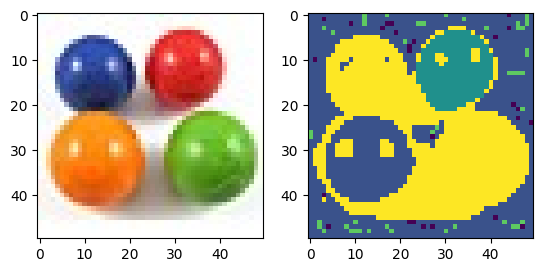

In [347]:
image_segmentation(laplacian_normalization = 'rw', num_classes = 5, chosen_eig_indices = None,  k = 3)

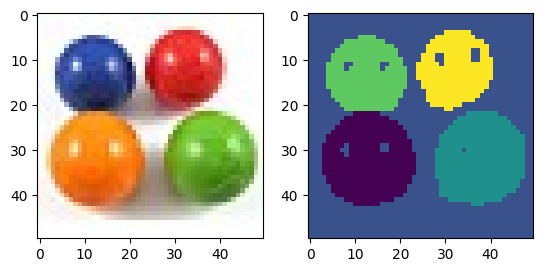

In [345]:
image_segmentation(laplacian_normalization = 'rw', num_classes = 5, chosen_eig_indices = None,  k = 15)

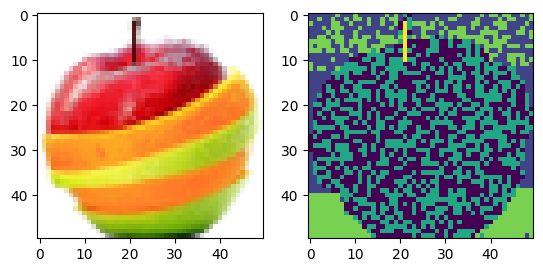

In [357]:
image_segmentation(input_img="fruit_salad.bmp", num_classes=6, k=3)

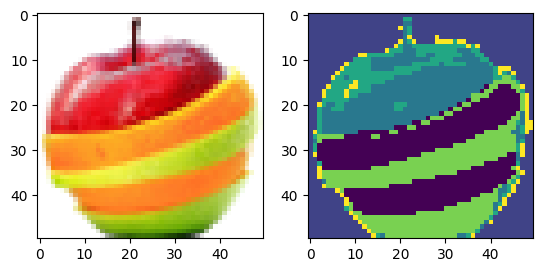

In [356]:
image_segmentation(input_img="fruit_salad.bmp", num_classes=6, k=100)

Encore une fois la bonne connexité de notre graphe de similarité est primordiale pour avoir une segmentation pertinente.

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

La limitation étant avant tout un problème mémoire, l'idée est de se ramener à des images plus petites.
Le plus rapide est de réduire la résolution, faire le clustering puis faire une super-résolution sur la segmentation obtenu avec un flou gaussien pour diminuer l'aliasing de la segmentation.

Pour la suite ce sont juste des idées qui me viennent et par manque de temps je ne pourrais pas les tester et voir si des méthodes analogue existent et sont utilisé, c'est ainsi purement informel.  

Premièrement, on pourrait imaginer combiner des segmentations des portions de l'image et faire un appariement des différentes classes sur les bords en testant si la fusion entre deux cluster est pertinent.
Ou alors, avec un clustering sur l'image à faible résolution on pourrait déterminer une structure dans notre laplacien et s'amener à une base tel qu'il est diagonal par block. Puis on utiliserait cette information pour détailler chaque block du laplacien par des graphes de similarité associées à la bonne région de l'image. La résolution sur chacun des sous parties combinée à l'indépendance des régions permet alors de réduire le problème
puis par concaténation vecteurs propres on achève la classificationrix 
.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

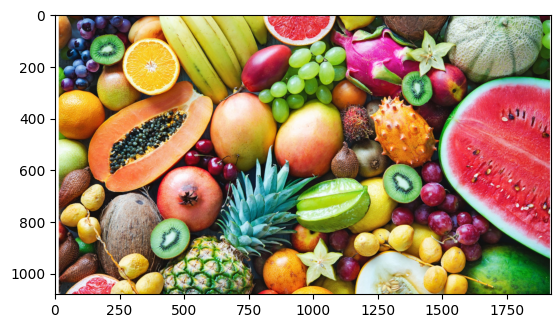

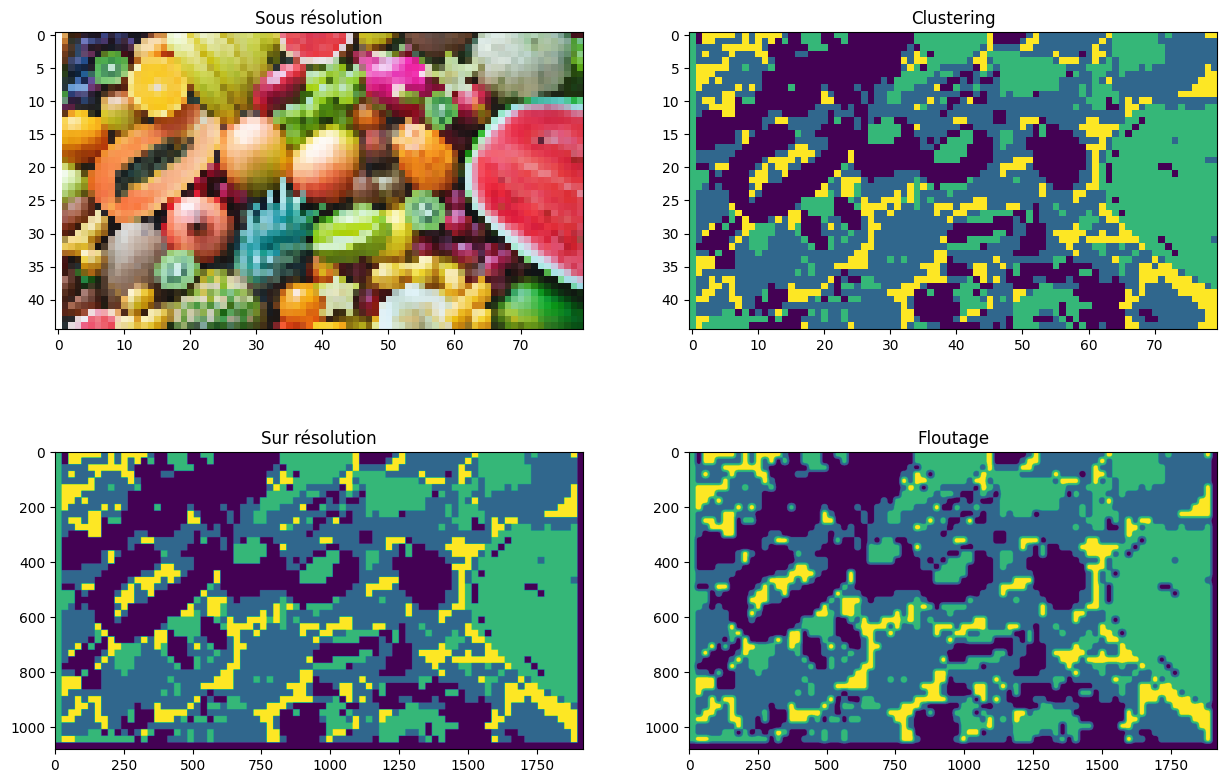

In [618]:
filename = 'data//fruta-hd.jpg'
img = io.imread(filename)[:,:,:3]
img1 = (img - np.min(img)) / (np.max(img) - np.min(img))
plt.imshow(img1)
m, n, l = img1.shape

num_classes = 4
r = 24

# Sous résolution par la médiane
img2 = np.zeros((m//r, n//r,l))
for k in range(l):
    for i in range(m//r):
        for j in range(n//r):
            img2[i,j,k] = np.median(img1[i*r:(i+1)*r,j*r:(j+1)*r, k], axis = (0,1))
# img2 =  cv2.GaussianBlur(img2,(3,3),0)

#Clustering
mr, nr, _ = img2.shape
X = img2.reshape(mr * nr , 3)
W = build_similarity_graph(X, var=2.0, k=200)
L = build_laplacian(W, laplacian_normalization='rw')
Y_rec = spectral_clustering(L, None, num_classes=num_classes)
Y_rec = Y_rec.reshape(mr, nr)

# Sur résolution
img3 = np.zeros((m, n))
for i in range(0, m-r, r):
    for j in range(0, n-r, r):      
        img3[i, j] = Y_rec[i//r][j//r]
for i in range(1, m-(r-1), r):
    for j in range(0, n-(r-1)):
        img3[i:i+(r-1), j] = img3[i-1, j]
for i in range(0, m-1):
    for j in range(1, n-1, r):
        img3[i, j:j+(r-1)] = img3[i, j-1]
        
# Floutage
img4 = cv2.GaussianBlur(img3.astype(np.uint8),(35,35),0)
fig , ax = plt.subplots(2,2,figsize=(15,10))
ax[0,0].imshow(img2)
ax[0,0].set_title('Sous résolution')
ax[0,1].imshow(Y_rec)
ax[0,1].set_title('Clustering')
ax[1,0].imshow(img3)
ax[1,0].set_title('Sur résolution')
ax[1,1].imshow(img4)
ax[1,1].set_title('Floutage')
plt.show()